This is the notebook dedicated to running our models

Gather the dataset and imports

In [1]:
import sys
import os
import torch
import torch.optim as optim
import torch.nn as nn
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from data.data_preprocessing import MRIDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import pickle

# Applying random transformations to vary data
transformations = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

# Data preloaded from pickle file
data_path = os.path.abspath(os.path.join("..", "data", "archive", "brain_tumor_mri", "new_dataset", "training_data.pickle"))
with open(data_path, 'rb') as file:
    loaded_data = pickle.load(file)

# Unpacking the data into the images and their corresponding labels
images, labels = zip(*loaded_data)
dataset = MRIDataset(images, labels, transformations, model_type=None)

# Splitting the dataset into training and testing
training_size = int(.8 * len(dataset))
testing_size = len(dataset) - training_size
training_dataset, testing_dataset = random_split(dataset, [training_size, testing_size])

# Two separate loaders for training and testing
train_loader = DataLoader(training_dataset, batch_size=16, shuffle=True)
testing_loader = DataLoader(testing_dataset, batch_size=16, shuffle=True)

# Debug comment out later
for sample_image, sample_label in train_loader:
    print(f"Image shape: {sample_image.shape}")
    print(f"Label: {sample_label}")
    break


Image shape: torch.Size([16, 1, 512, 512, 3])
Label: tensor([2., 1., 2., 1., 1., 1., 3., 2., 2., 1., 2., 2., 2., 3., 2., 2.])


Run the 3D CNN model

Batch number 0, Loss: 0.6257138848304749
Batch number 1, Loss: 0.36962413787841797
Batch number 2, Loss: 0.8353097438812256
Batch number 3, Loss: 1.2334660291671753
Batch number 4, Loss: 0.6474841833114624
Batch number 5, Loss: 0.6480945944786072
Batch number 6, Loss: 0.4137726426124573
Batch number 7, Loss: 0.9679609537124634
Batch number 8, Loss: 0.5466925501823425
Batch number 9, Loss: 0.4865577816963196
Batch number 10, Loss: 0.33490878343582153
Batch number 11, Loss: 2.348973035812378
Batch number 12, Loss: 0.8285627365112305
Batch number 13, Loss: 0.4032406508922577
Batch number 14, Loss: 0.7380245327949524
Batch number 15, Loss: 0.4194735288619995
Batch number 16, Loss: 0.2935454845428467
Batch number 17, Loss: 0.4986476004123688
Batch number 18, Loss: 0.5942906737327576
Batch number 19, Loss: 0.3757671117782593
Batch number 20, Loss: 1.0316650867462158
Batch number 21, Loss: 0.4802986979484558
Batch number 22, Loss: 0.4743293821811676
Batch number 23, Loss: 0.3990645408630371
B

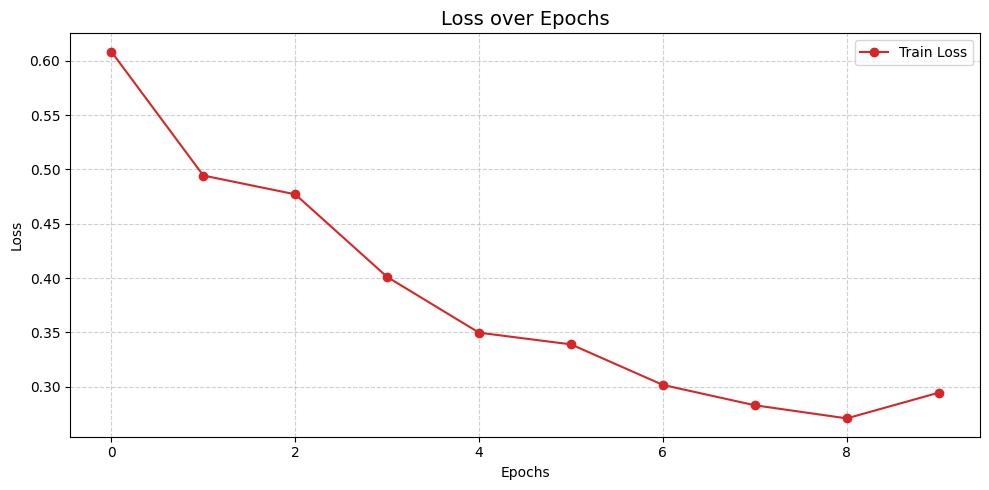

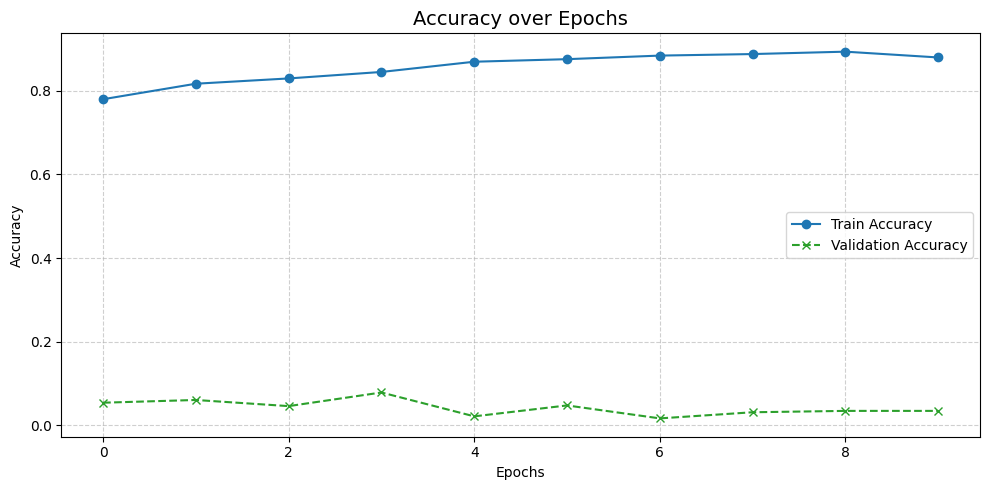

Model saved at models/3D_CNN/checkpoints/cnn_3d_training.pth


In [3]:
from models.CNN_3D.model import CNN_3D
from models.CNN_3D.train import Trainer

# Set up the model, criterion, and optimizer
model = CNN_3D(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

torch.cuda.empty_cache()
torch.cuda.ipc_collect()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

model.load_state_dict(torch.load("models/3D_CNN/checkpoints/cnn_3d.pth"))

# Initialize the Trainer class
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=testing_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
)

trainer.train()

Run the ResNet model

In [ ]:
from models.ResNet.model import ResNet
from models.ResNet.train import train

model = ResNet()

Run the Inception model

In [ ]:
from models.Inception.model import Inception
from models.Inception.train import train

model = Inception()

Visualize Models

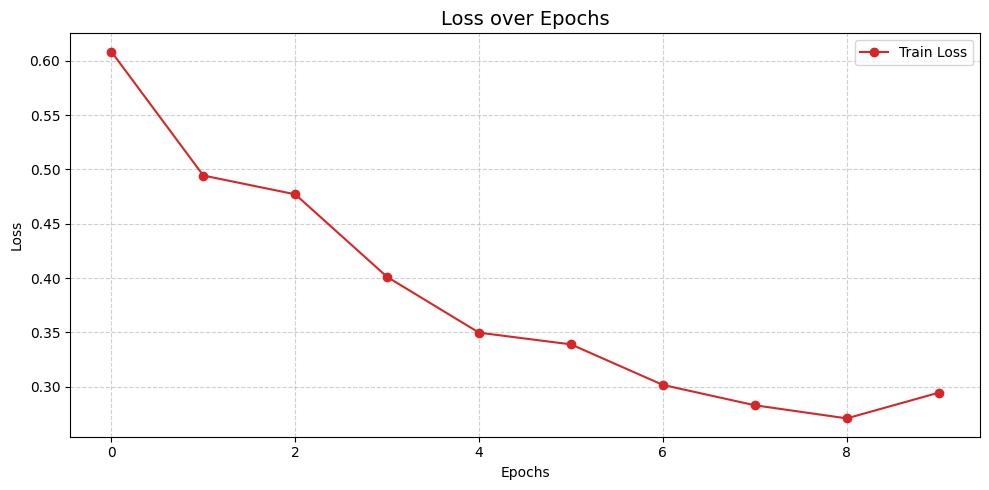

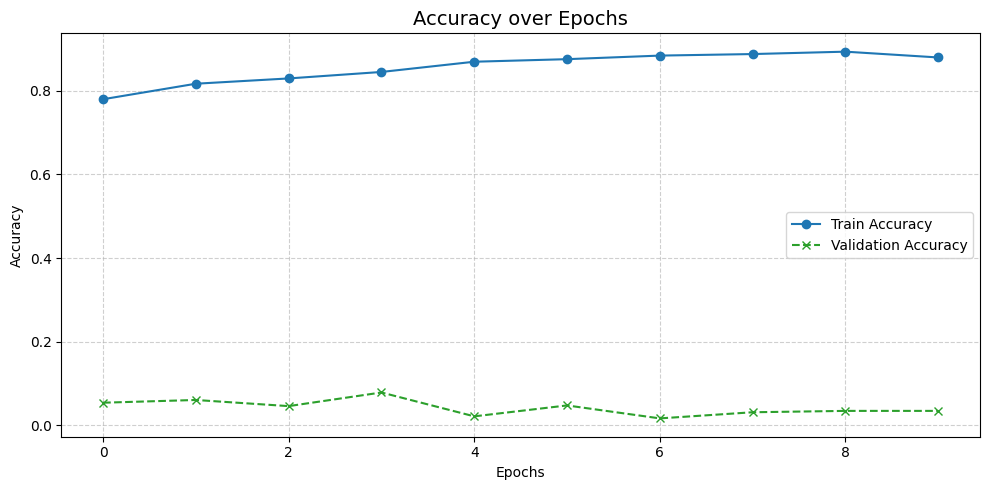

d:\CS 4644 Project\TumorTrace\utils\visualization.py:50: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


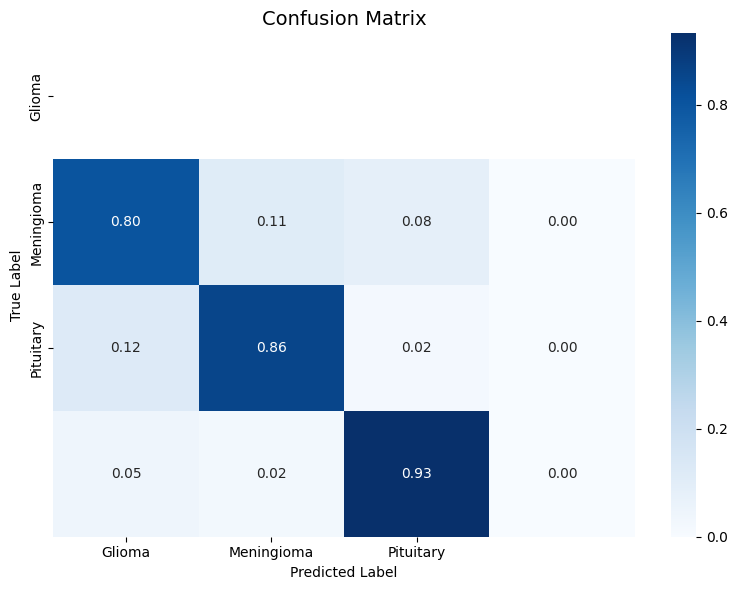


Classification Report:

              precision    recall  f1-score   support

      Glioma       0.72      0.80      0.76       143
  Meningioma       0.93      0.86      0.89       293
   Pituitary       0.90      0.93      0.92       177

    accuracy                           0.87       613
   macro avg       0.85      0.86      0.86       613
weighted avg       0.87      0.87      0.87       613

Saved training plots to results/figures/


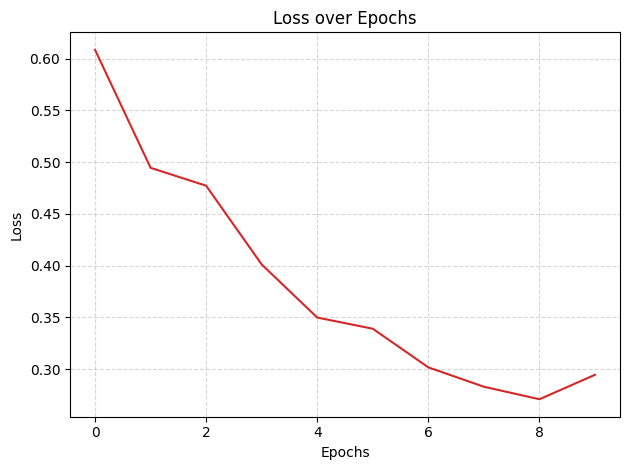

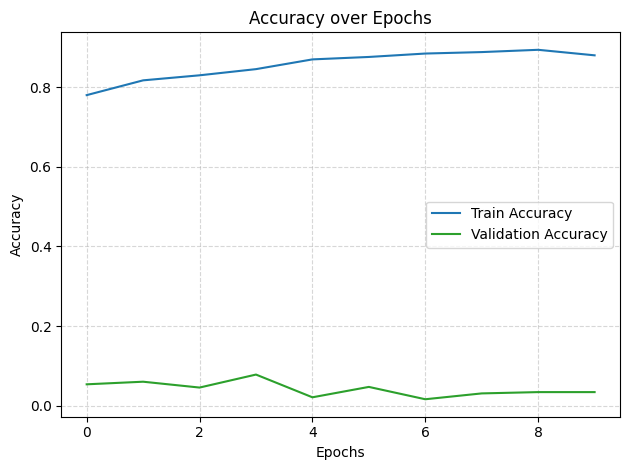

In [4]:
# Plot training curves
trainer.visualizer.plot_loss()
trainer.visualizer.plot_accuracy()

# Re-evaluate model and retrieve predictions
val_accuracy, y_true, y_pred = trainer.evaluate(return_preds=True)

# Visualize confusion matrix and classification report
trainer.visualizer.evaluation_summary(y_true, y_pred)

# Save all plots
trainer.visualizer.save_plots("results/figures/")